In [1]:
import pandas as pd
import os
import json
import pytz
# Plotting imports
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cm

In [2]:
def labeler_uniques(df: pd.DataFrame, column_name: str) -> dict:
    # Get unique values in the specified column
    unique_values = df[column_name].unique()
    
    # Create a dictionary mapping each unique value to a unique number
    unique_dict = {value: i for i, value in enumerate(unique_values)}
    
    return unique_dict
    
def add_mapped_column(df: pd.DataFrame, column_name: str, new_column_name: str) -> pd.DataFrame:
    # Get unique values and create a dictionary mapping each unique value to a unique number
    unique_dict = labeler_uniques(df, column_name)
    
    # Use the map function to create a new column with the mapped values
    df[new_column_name] = df[column_name].map(unique_dict)
    
    return df

In [3]:
def retrieve_data(data_path = "../data1/", start_idx=0, stop_idx=60):
    # list to store files
    f_store = []
    results = {}
    columns = []
    
    # Iterate directory
    for file_name in os.listdir(data_path):
        # check if current file_path is a file
        if os.path.isfile(os.path.join(data_path, file_name)):
            # add filename to list
            f_store.append(file_name)

    flag = True
    for file_name in f_store:
        data = {}
        tmp_dt = ''
        # Open the JSON file
        with open(data_path + file_name) as file:
            data = json.load(file)
        for i in range(start_idx, stop_idx+1):
            try:
                if data:
                    if i == start_idx:
                        tmp_dt = data[str(i)]['timestamp']
                    
                    if file_name == f_store[0]:
                        columns.append(data[str(i)]['name'])
                    if flag:
                        if i == start_idx:
                            results['timestamp'] = [tmp_dt]
                        results[columns[i]] = [data[str(i)]['value']]
                    else:
                        if i == start_idx:
                            results['timestamp'].append(tmp_dt)
                        results[columns[i]].append(data[str(i)]['value'])
            except KeyError:
                print(file_name)
                print(i)
                pass
        flag = False
    #print(results)
    return results

In [4]:
def annotation_plot(df, fields, names, units, annotations):
    # Create a figure with subplots
    num_fields = len(fields)
    fig, axes = plt.subplots(num_fields, 1, figsize=(15, 5 * num_fields))
    fig.subplots_adjust(hspace=0.5)  # Adjust space between subplots

    # Create timezone for x-axis formatting
    est = pytz.timezone('US/Eastern')
    myFmt = mdates.DateFormatter('%H:%M', tz=est)

    # Get unique labels from the annotations and assign colors to them
    unique_labels = annotations.iloc[:, -1].unique()  # Last column is the numeric label
    colors = plt.get_cmap('tab10', len(unique_labels))  # Generate different colors

    # Create a mapping between labels and colors
    label_to_color = {label: colors(i) for i, label in enumerate(unique_labels)}

    # Iterate through the fields and create individual plots
    for idx in range(num_fields):
        temp = df[[fields[idx]]]
        axes[idx].plot(df['EST'], temp, label=names[idx])
        
        # Set x-axis formatter and labels
        axes[idx].xaxis.set_major_formatter(myFmt)
        axes[idx].set_xlabel('Time (HH:MM)')
        axes[idx].set_ylabel(f'{names[idx]} ({units[idx]})')  # Use unit from the units list
        axes[idx].set_title(f'{names[idx]} Over Time')

        c = []
        # Add vertical lines for each annotation
        for i, row in annotations.iterrows():
            timestamp = row['Time_UTC']  # Assuming the timestamp is in the first column
            label = row['Label']  # Assuming the label is in the last column
            color = label_to_color[label]
            name = row['Identifier']
            
             # Plot vertical line, only assign label to the first occurrence of the label
            if color not in c:
                axes[idx].axvline(pd.to_datetime(timestamp), color=color, linestyle='--', label=f'Label {name}')
                c.append(color)
            else:
                axes[idx].axvline(pd.to_datetime(timestamp), color=color, linestyle='--', label='_nolegend_')

    # Add a legend to each subplot
    for ax in axes:
        ax.legend()

    plt.show()

In [5]:
df_working = pd.read_csv('MMRI_annotations 22-08-2024_2.csv', skiprows=1)
#df_working['Time']= pd.to_datetime(df_working['Time'],  format='%H:%M:%S')
# Assuming df_working['Time'] has time in HH:MM:SS format
df_working['Time'] = pd.to_datetime('2024-08-22 ' + df_working['Time'].astype(str), format='%Y-%m-%d %H:%M:%S')


# Add 5 hours to the 'Time' column
df_working['Time'] = df_working['Time'] + pd.Timedelta(hours=3, minutes=54, seconds=1)

# Localize to EDT (Eastern Daylight Time)
eastern = pytz.timezone('EST')
df_working['Time_EDT'] = df_working['Time'].dt.tz_localize(eastern)

# Convert to UTC
df_working['Time_UTC'] = df_working['Time_EDT'].dt.tz_convert('UTC')
#df_working.head()

In [6]:
add_mapped_column(df_working, 'Identifier', 'Label') 
df_working.head(10)

,Time,Human,Event,Identifier,Time_EDT,Time_UTC,Label
0,2024-08-22 18:25:21,YL,Material start to get out of nozzle,System,2024-08-22 18:25:21-05:00,2024-08-22 23:25:21+00:00,0
1,2024-08-22 18:26:44,YL,Pump stop,System,2024-08-22 18:26:44-05:00,2024-08-22 23:26:44+00:00,0
2,2024-08-22 18:27:05,YL,Pump auto,System,2024-08-22 18:27:05-05:00,2024-08-22 23:27:05+00:00,0
3,2024-08-22 18:34:33,YL,Accelerator in printhead,System,2024-08-22 18:34:33-05:00,2024-08-22 23:34:33+00:00,0
4,2024-08-22 18:35:25,YL,Color change,Extrudate good,2024-08-22 18:35:25-05:00,2024-08-22 23:35:25+00:00,1
5,2024-08-22 18:35:54,YL,Accelerator pump down to 48,System,2024-08-22 18:35:54-05:00,2024-08-22 23:35:54+00:00,0
6,2024-08-22 18:37:52,YL,"First zigzag print (5%accelerator, 200)",Printing,2024-08-22 18:37:52-05:00,2024-08-22 23:37:52+00:00,2
7,2024-08-22 18:39:23,YL,Print finish,Printing,2024-08-22 18:39:23-05:00,2024-08-22 23:39:23+00:00,2
8,2024-08-22 18:39:48,YL,Mixing speed 300,System,2024-08-22 18:39:48-05:00,2024-08-22 23:39:48+00:00,0
9,2024-08-22 18:41:47,YL,Second zigzag line,Printing,2024-08-22 18:41:47-05:00,2024-08-22 23:41:47+00:00,2


In [7]:
res=retrieve_data(data_path = "../data2/")
df = pd.DataFrame.from_dict(res)
df['timestamp']= pd.to_datetime(df['timestamp'],  format='%d.%m.%Y %H:%M:%S,%f')
df['EST'] = (df.timestamp.dt.tz_localize('UTC').dt.tz_convert('US/Eastern'))
#df.head()

In [8]:
fields = [
    'GECO/MP_Pump_Pressure_Current_bar_R',
    'GECO/MPTX_DI_Water_Temperature_C_R',
    'GECO/MPXMB_Pump_OutputCurrent_dA_I',
    'GECO/MPXMB_Pump_OutputPower_W_I',
    'GECO/MPTX_DI_Mortar_Temperature_C_R',
#    'GECO/MPTX_DI_Air_Temperature_C_R' 
]

names = [
    'Pump Pressure',
    'Water Temp',
    'Pump Current',
    'Pump Power',
    'Mortar Tempurature',
#    'Ambient Temp'
]

units = [
    'BAR',
    'C',
    'dA',
    'W',
    'C'
#    'C'
]

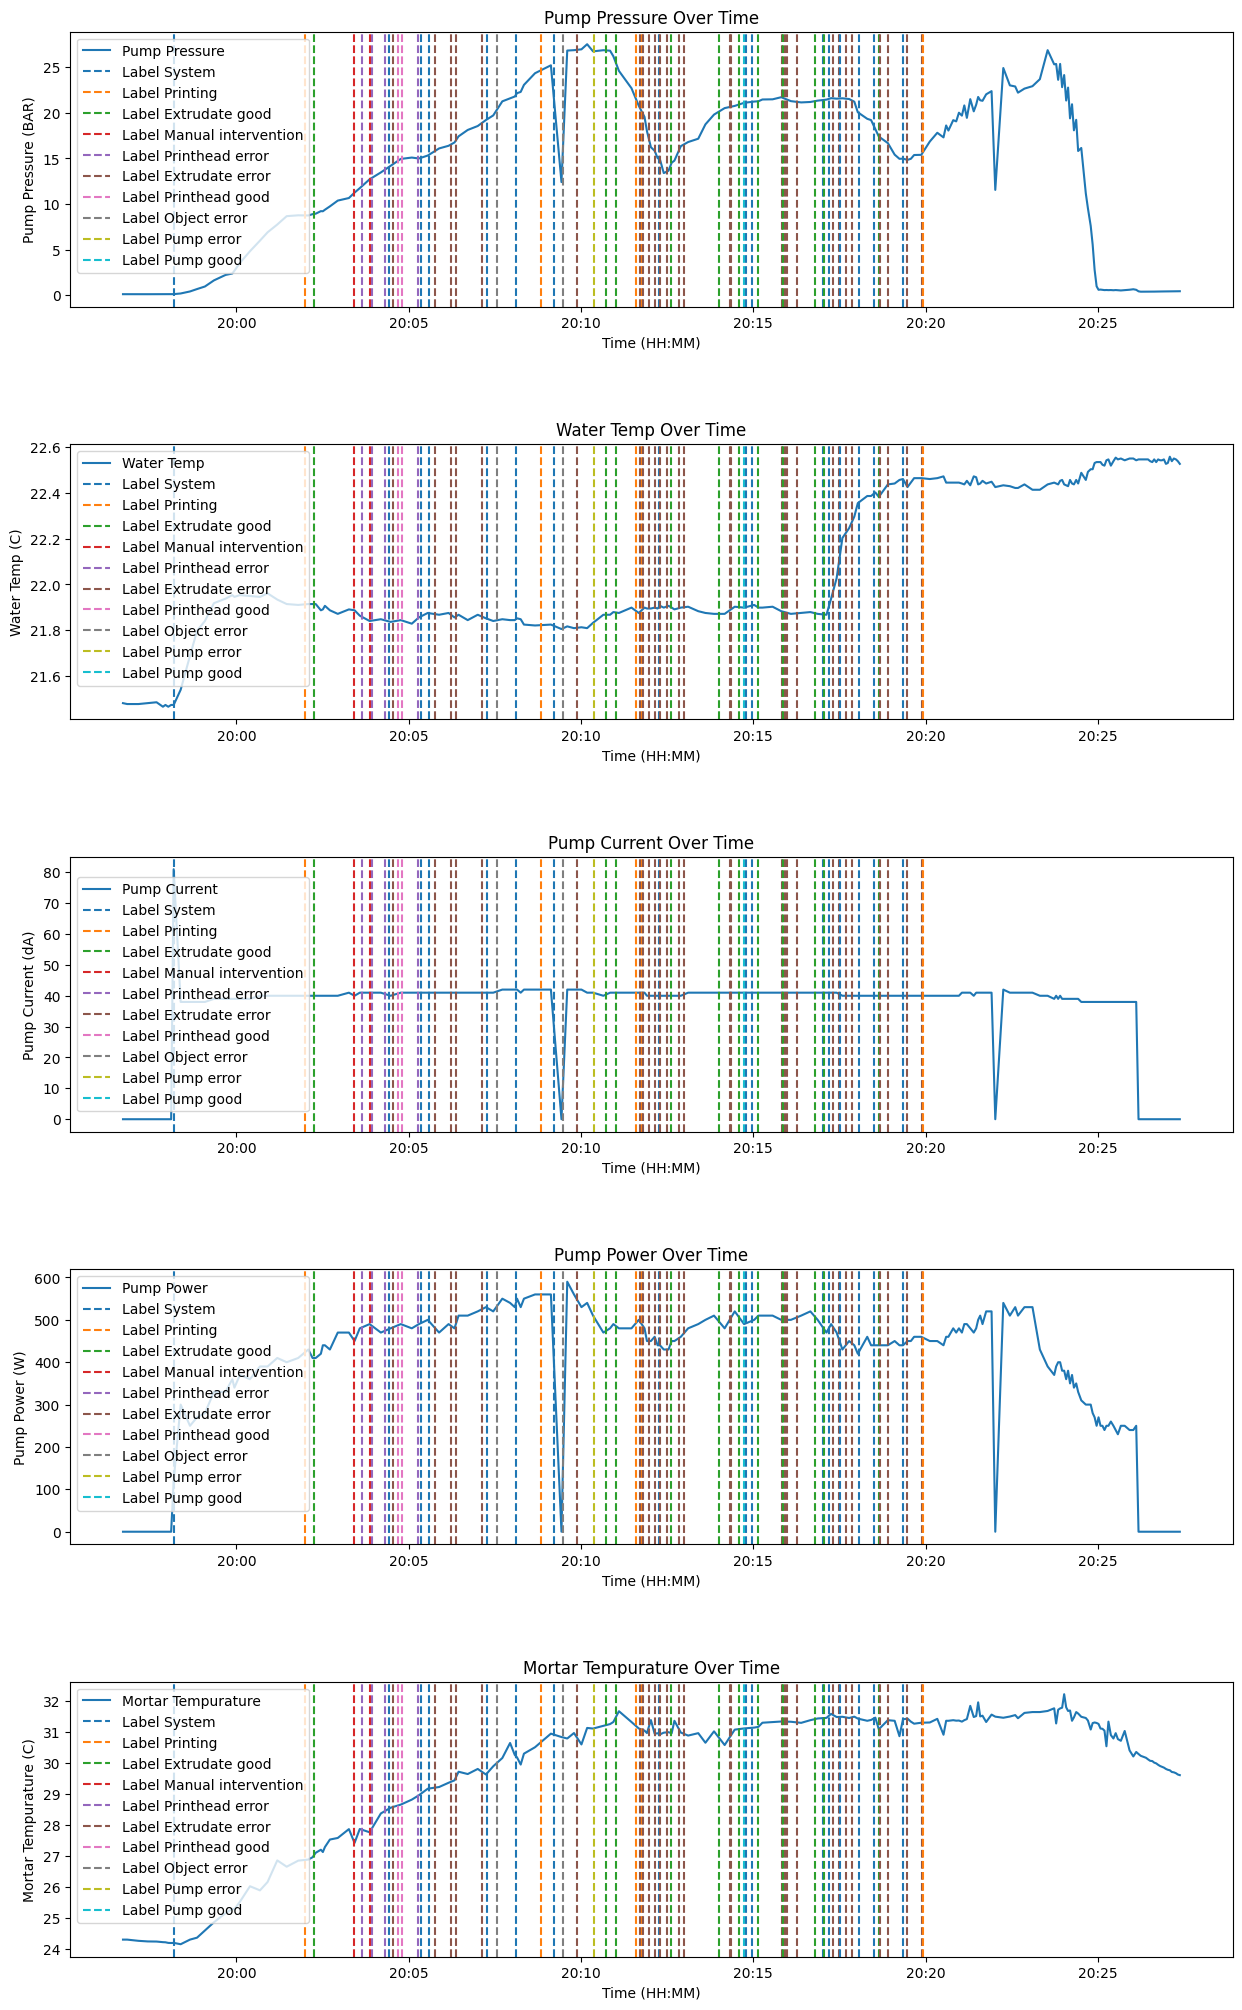

In [9]:
# Shit Material
annotation_plot(df[1500:1700], fields, names, units, df_working[18:])

In [10]:
df_working[18:].head(70)

,Time,Human,Event,Identifier,Time_EDT,Time_UTC,Label
18,2024-08-22 18:58:11,CW,Pump Start,System,2024-08-22 18:58:11-05:00,2024-08-22 23:58:11+00:00,0
19,2024-08-22 19:01:59,AK,start printing first layer Box (A),Printing,2024-08-22 19:01:59-05:00,2024-08-23 00:01:59+00:00,2
20,2024-08-22 19:02:16,AK,"AK, YL notice the quality of the printing is h...",Extrudate good,2024-08-22 19:02:16-05:00,2024-08-23 00:02:16+00:00,1
21,2024-08-22 19:03:24,AK,CW to AK add some water because its not gonna ...,Manual intervention,2024-08-22 19:03:24-05:00,2024-08-23 00:03:24+00:00,4
22,2024-08-22 19:03:39,AK,2K head starts leaking red fluid,Printhead error,2024-08-22 19:03:39-05:00,2024-08-23 00:03:39+00:00,5
...,...,...,...,...,...,...,...
83,2024-08-22 19:18:38,AK,Filament starts to look more stable,Extrudate good,2024-08-22 19:18:38-05:00,2024-08-23 00:18:38+00:00,1
84,2024-08-22 19:18:41,AK,under extrusion,Extrudate error,2024-08-22 19:18:41-05:00,2024-08-23 00:18:41+00:00,3
85,2024-08-22 19:18:54,AK,Under extrusion continues and looks worse,Extrudate error,2024-08-22 19:18:54-05:00,2024-08-23 00:18:54+00:00,3
86,2024-08-22 19:19:20,AK,Add new accelerator,System,2024-08-22 19:19:20-05:00,2024-08-23 00:19:20+00:00,0


In [11]:
def torque_annotation_plot(df, annotations):
    # Create a figure
    fig, ax = plt.subplots(figsize=(15, 10))

    # Create timezone for x-axis formatting
    est = pytz.timezone('US/Eastern')
    myFmt = mdates.DateFormatter('%H:%M', tz=est)

    # Get unique labels from the annotations and assign colors to them
    unique_labels = annotations['Label'].unique()  # Assuming 'Label' is the column with labels
    colors = plt.get_cmap('tab10', len(unique_labels))  # Generate different colors

    # Create a mapping between labels and colors
    label_to_color = {label: colors(i) for i, label in enumerate(unique_labels)}

    # Plot the torque data against the 'Unit Offset'
    ax.plot(df['Time'], df['0'], label='Torque')

    # Set x-axis formatter and labels
    ax.xaxis.set_major_formatter(myFmt)
    ax.set_xlabel('Time (HH:MM)')
    ax.set_ylabel('Torque')
    ax.set_title('Torque Over Time')

    c = []
    # Add vertical lines for each annotation
    for i, row in annotations.iterrows():
        timestamp = row['Time_UTC']  # Assuming this is the column with UTC timestamps
        label = row['Label']  # Assuming this is the column with labels
        color = label_to_color[label]
        name = row['Identifier']  # If you have an 'Identifier' column for names
        
         # Plot vertical line, only assign label to the first occurrence of the label
        if color not in c:
            ax.axvline(pd.to_datetime(timestamp), color=color, linestyle='--', label=f'Label {name}')
            c.append(color)
        else:
            ax.axvline(pd.to_datetime(timestamp), color=color, linestyle='--', label='_nolegend_')

    # Add a legend to the plot
    ax.legend()

    plt.show()

In [12]:
import pandas as pd
from datetime import datetime, timedelta

# File path for the CSV (update this if needed)
file_path = './22-08-2024_NorthPLC.csv'

# Load data into DataFrame
df_torque = pd.read_csv(file_path, header=0, skiprows=22)

C:\Users\cjwattz\AppData\Local\Temp\1\ipykernel_29492\561243473.py:8: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df_torque = pd.read_csv(file_path, header=0, skiprows=22)


In [13]:
# Step 1: Convert the 'Time' column to string (if not already)
df_torque['Unit Offset'] = df_torque['Unit Offset'].astype(str)

# Step 2: Trim whitespace
df_torque['Unit Offset'] = df_torque['Unit Offset'].str.strip()
# Step 2: Convert to numeric, coercing errors to NaN
df_torque['Unit Offset'] = pd.to_numeric(df_torque['Unit Offset'], errors='coerce')
df_torque = df_torque.dropna()

In [14]:
# Extract Starttime and Endtime from cells B3 and B4
starttime = 133688387309500000  # Example value from your image, should ideally be read programmatically if possible
endtime = 133688416054380000  # Example value from your image, should ideally be read programmatically if possible

# Convert start and end times to datetime objects (use actual date/time from your cells C3 and F3)
start_date = datetime(2024, 8, 22, 18, 18, 51, 0)
end_date = datetime(2024, 8, 22, 19, 6, 45, 45)

# Calculate the total number of seconds in the mapped datetime range
total_seconds = (end_date - start_date).total_seconds()

# Calculate time mapping factor (seconds per unit in the original timestamp)
time_per_unit = total_seconds / (endtime - starttime)

# Convert timestamps in column 1
def convert_timestamp(ts):
    # Calculate the time delta based on the original timestamp using floating-point multiplication
    time_delta_seconds = (ts - starttime) * time_per_unit

    #print(time_delta_seconds)
    # Add this delta to the start date
    return start_date + timedelta(seconds=time_delta_seconds)

#def add_time()

# Apply conversion to the first column of the DataFrame
df_torque.iloc[:, 0] = df_torque.iloc[:, 0].apply(convert_timestamp)

# Save the modified DataFrame to a new CSV file
#output_path = 'head_torque_8-22-24.csv'
#df.to_csv(output_path, index=False)

#print("Timestamps converted and data saved to", output_path)

#convert_timestamp(df_cleaned['Unit Offset'][80])

C:\Users\cjwattz\AppData\Local\Temp\1\ipykernel_29492\2084574540.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0         2024-08-22 18:18:51.000000
1         2024-08-22 18:18:51.001000
2         2024-08-22 18:18:51.002000
3         2024-08-22 18:18:51.002999
4         2024-08-22 18:18:51.003999
                     ...            
2874484   2024-08-22 19:06:44.996046
2874485   2024-08-22 19:06:44.997046
2874486   2024-08-22 19:06:44.998045
2874487   2024-08-22 19:06:44.999045
2874488   2024-08-22 19:06:45.000045
Name: Unit Offset, Length: 2874489, dtype: datetime64[ns]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_torque.iloc[:, 0] = df_torque.iloc[:, 0].apply(convert_timestamp)


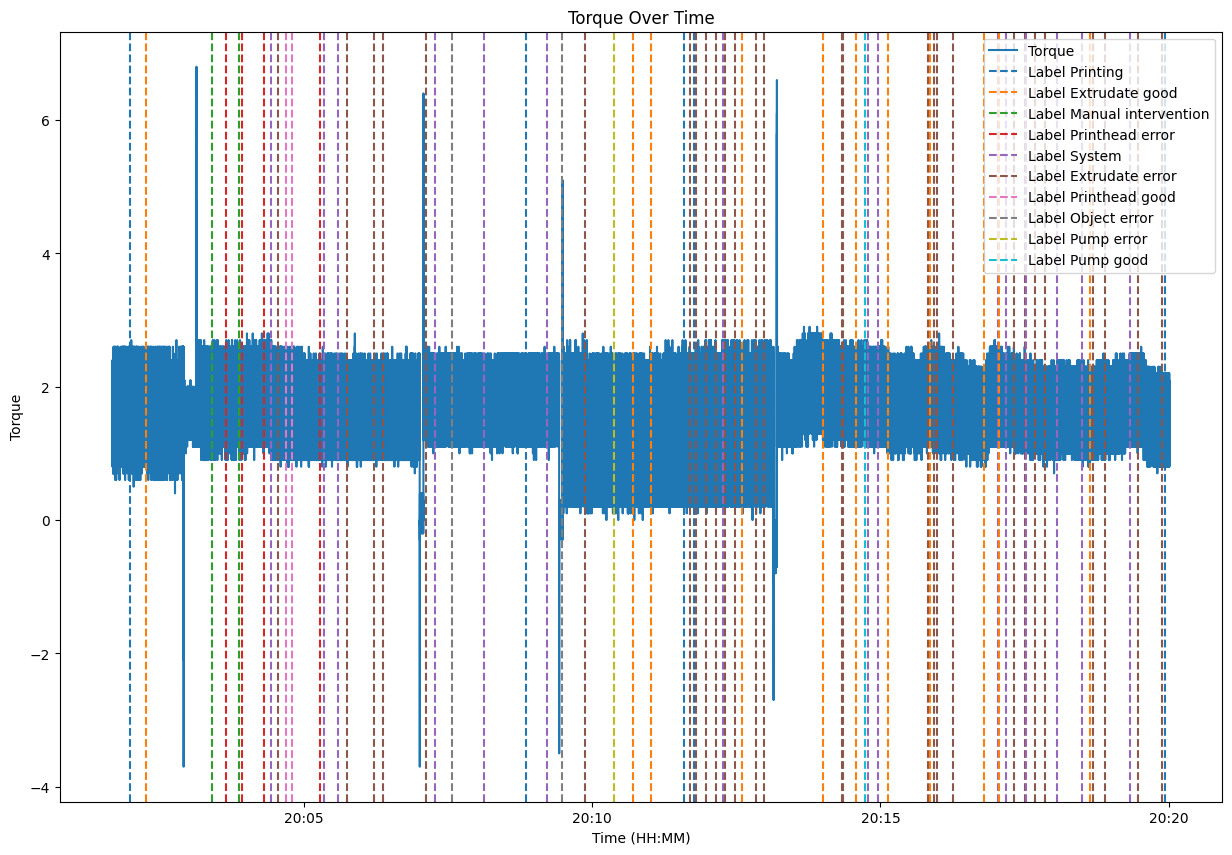

In [15]:
# Add 5 hours to the 'Time' column
df_torque['Time'] = df_torque['Unit Offset'] + pd.Timedelta(hours=5, minutes=24, seconds=30)
df.reset_index(drop=True, inplace=True)
torque_annotation_plot(df_torque[1100000:2200000], df_working[19:])

In [16]:
plt.plot(df_cleaned['Unit Offset'], df_cleaned['0'])

NameError: name 'df_cleaned' is not defined

In [ ]:
len(df_torque)

In [19]:
df_working[18:].to_csv('annotations3boxes.csv')